In [1]:
import random
import sys
import os
import json
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import torch
import torch.nn as nn
import torch.nn.functional as F

from glob import glob
from typing import List, Mapping, Tuple, Optional, Any
from collections import OrderedDict
from tqdm.notebook import tqdm
from torch.nn.modules.loss import _WeightedLoss
from catalyst import dl
from catalyst.dl import utils
from catalyst.dl import SupervisedRunner
from catalyst.contrib.nn.optimizers import RAdam, Lookahead, Adam
from catalyst.dl.callbacks import OptimizerCallback, EarlyStoppingCallback, SchedulerCallback, CriterionCallback, CheckpointCallback
from ranger_adabelief import RangerAdaBelief 
from adabelief_pytorch import AdaBelief

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib import pyplot as plt

from basic_utils.data import slice_sequances, anton_slicer
from basic_utils.metric import map_per_set, map_per_image, mean_average_precision_at_k, average_precision_at_k
from nn_utils.swa import avarage_weights
from nn_utils.callbacks import MAP5Callback, CinemaMAP5Callback

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Cur device : {DEVICE}')

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    torch.manual_seed(seed_value)    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(1234)

Cur device : cuda


In [3]:
BS = 2048
SEQ_LEN = 75
EXP_NAME = 'antonlsrm_antonseqs_2048bs_75seqlen_rmsprop_byloss_fixedagainmetric_ratereemb_correctstretifiedval'

## Load data

In [4]:
movies_ts = pd.read_csv('/ssd_data/cinema_hack/movies_dataset_10 months.csv')
movies_ts['ts'] = pd.to_datetime(movies_ts['ts'])
movies_ts = movies_ts.sort_values('ts').reset_index(drop=True)

In [5]:
sample_submission = pd.read_csv('/ssd_data/cinema_hack/submission.csv')

sample_submission['movie_id'] = sample_submission[' movie_id']
sample_submission = sample_submission.drop(columns=' movie_id')

In [6]:
with open("../add_data/ActorEmbed.json", "r") as read_file:
    actor_emb = json.load(read_file)
    actor_emb = {int(k):torch.Tensor(v) for k,v in actor_emb.items()}
    
with open("../add_data/DirectorEmbed.json", "r") as read_file:
    director_emb = json.load(read_file)
    director_emb = {int(k):torch.Tensor(v) for k,v in director_emb.items()}
    
with open("../add_data/GenreEmbed.json", "r") as read_file:
    genre_emb = json.load(read_file)
    genre_emb = {int(k):torch.Tensor(v) for k,v in genre_emb.items()}
    
with open("../add_data/ratingembed.json", "r") as read_file:
    rate_emb = json.load(read_file)
    rate_emb = {int(k):torch.Tensor(v) for k,v in rate_emb.items()}

In [7]:
missed_movies = set(movies_ts['movie_id']) - set(list(map(int, actor_emb.keys())))
for el in missed_movies:
    actor_emb[el] = torch.zeros_like(actor_emb[1])
    director_emb[el] = torch.zeros_like(director_emb[1])
    genre_emb[el] = torch.zeros_like(genre_emb[1])
    rate_emb[el] = torch.zeros_like(rate_emb[1])

## Prepare data

In [8]:
le_film_id = preprocessing.LabelEncoder()

# Increase train index for zero padding
movies_ts['movie_id'] = le_film_id.fit_transform(movies_ts['movie_id']) + 1

sequences = movies_ts.groupby('user_id')['movie_id'].apply(list)
sequences2use = sequences[sequences.apply(len) >= 10]

le_classes = le_film_id.classes_

In [9]:
GENRE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, genre_emb[0].shape[0]))
DIRECTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, director_emb[0].shape[0]))
ACTOR_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, actor_emb[0].shape[0]))
RATE_EMB = torch.zeros((le_film_id.classes_.shape[0]+1, rate_emb[0].shape[0]))

In [10]:
for i in range(le_classes.shape[0]):
    GENRE_EMB[i+1] = genre_emb[le_classes[i]]
    DIRECTOR_EMB[i+1] = director_emb[le_classes[i]]
    ACTOR_EMB[i+1] = actor_emb[le_classes[i]]
    RATE_EMB[i+1] = rate_emb[le_classes[i]]

In [11]:
maxlen = SEQ_LEN # Length of sequences in X
X = []
y = []

def slice_sequence(seq, num_slices):
    for i in range(1, num_slices):
        X.append(seq[-(i+maxlen+4): -(i+4)])
        if i == 1:
            y.append(seq[-(i+4):])
        else:
            y.append(seq[-(i+4):-(i-1)])
        
for seq in sequences2use:
    if len(seq) <= 5+5:
        slice_sequence(seq, 2)
    elif len(seq) <= 6+5:
        slice_sequence(seq, 3)
    elif len(seq) <= 8+5:
        slice_sequence(seq, 4)
    elif len(seq) <= 12+5:
        slice_sequence(seq, 6)
    elif len(seq) <= 16+5:
        slice_sequence(seq, 8)
    elif len(seq) <= 20+5:
        slice_sequence(seq, 11)
    elif len(seq) <= 26+5:
        slice_sequence(seq, 16)
    else:
        slice_sequence(seq, 23)

In [12]:
print(len(X), len(y))
print()
lens = [len(x) for x in X]
print(max(lens), min(lens), np.mean(lens), np.median(lens))

43774 43774

75 5 65.46006762004843 75.0


(array([  458.,  1127.,  1322.,  1440.,  1495.,  1444.,  1368.,  1343.,
         1378., 32399.]),
 array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21.]),
 <BarContainer object of 10 artists>)

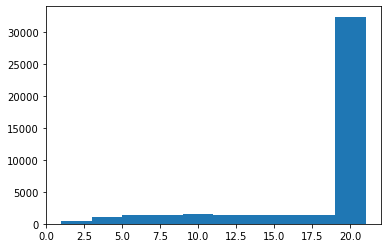

In [13]:
lens_discrit = np.digitize(lens, np.histogram(lens, bins=20)[1])
plt.hist(lens_discrit)

In [14]:
for i in range(len(X)):
    X[i] = [0]*(maxlen - len(X[i])) + X[i]

In [15]:
sequences_test = sequences.apply(lambda x: x[-maxlen:])
sequences_test = sequences_test.apply(lambda x: [0 for i in range(maxlen - len(x))] + x)

test_users_in_sequences = sorted(set(sequences_test.index) & set(sample_submission.user_id))

X_test = np.array(sequences_test[test_users_in_sequences].tolist())

In [16]:
X = np.array(X)
# Decrease target index 
y = np.array(y) - 1

In [17]:
X.shape, y.shape

((43774, 75), (43774, 5))

In [18]:
len(lens_discrit)

43774

## Train

In [19]:
class CinemaCE(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        return self.loss(input, target[:,0])
    
class CinemaCEModified(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, input, target):
        return (
             self.loss(input, target[:,0]) + 
            (self.loss(input, target[:,1])*(1/2)) +
            (self.loss(input, target[:,2])*(1/3)) +
            (self.loss(input, target[:,3])*(1/4)) +
            (self.loss(input, target[:,4])*(1/5))  
        )

In [20]:
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddding = nn.Embedding(4843+1, 64, padding_idx=0)
        self.rate_layer = nn.Embedding(RATE_EMB.shape[0], RATE_EMB.shape[1], _weight=RATE_EMB)
        self.rate_layer.weight.requires_grad = False
#         self.director_layer = nn.Embedding(DIRECTOR_EMB.shape[0], DIRECTOR_EMB.shape[1], _weight=DIRECTOR_EMB)
#         self.director_layer.weight.requires_grad = False
#         self.genre_layer = nn.Embedding(GENRE_EMB.shape[0], GENRE_EMB.shape[1], _weight=GENRE_EMB)
#         self.genre_layer.weight.requires_grad = False
        
        self.emb_dropout = nn.Dropout(0.01)
        self.lstms = nn.LSTM(
            input_size=64 + RATE_EMB.shape[1], #+ GENRE_EMB.shape[1],
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(128, 4843)
        )
       
    def forward(self, x):
        x = torch.cat([
            self.embeddding(x), self.rate_layer(x) #self.genre_layer(x)
        ], dim=-1)
        #x = self.embeddding(x)
        x = self.emb_dropout(x)
        seq, (hidden, _) = self.lstms(x)
        out = self.fc(hidden[-1])
        return out

In [21]:
def train_function(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    exp_name: str = EXP_NAME
):
    print(f"Train shapes: {X_train.shape, y_train.shape}")
    print(f"Test shapes: {X_val.shape, y_val.shape}")
    dataset_train = torch.utils.data.TensorDataset(
        X_train,
        y_train
    )
    dataloader_train = torch.utils.data.DataLoader(dataset_train, BS, shuffle=True, drop_last=True)

    dataset_val = torch.utils.data.TensorDataset(
        X_val,
        y_val
    )
    dataloader_val = torch.utils.data.DataLoader(dataset_val, BS)

    loaders = {'train':dataloader_train, 'valid': dataloader_val}
   
    model = BaselineModel().to(DEVICE)
    print(model)

    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min')

    criterion =  CinemaCE()#nn.CrossEntropyLoss()

    callbacks =[
                CinemaMAP5Callback(),
                OptimizerCallback(metric_key="loss", accumulation_steps=1),
                EarlyStoppingCallback(patience=10, metric='loss', minimize=True),
                SchedulerCallback(mode='epoch', reduced_metric="loss"),
                CheckpointCallback(save_n_best=3)
            ]

    runner = SupervisedRunner()

    # Train 
    runner.train(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            loaders=loaders,
            logdir=exp_name,
            num_epochs=999,
            verbose=True,
            main_metric="loss",
            minimize_metric=True,
            callbacks=callbacks
        ) 
    
def inference_function(
    X_array: torch.Tensor,
    exp_name: str,
    return_logits: bool = False
):
    dataset = torch.utils.data.TensorDataset(
        X_array,
        torch.zeros_like(X_array)
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS)
    
    runner = SupervisedRunner()
    prediction = runner.predict_loader(
        loader=dataloader, 
        model=BaselineModel().to(DEVICE), 
        resume=f'{exp_name}/checkpoints/best.pth'
    )
    prediction = torch.cat([b['logits'].detach().cpu() for b in prediction])
    if return_logits:
        prediction = prediction.numpy()
    else:
        prediction = torch.sort(-prediction, 1).indices[:,:5].numpy()
    
    return prediction

Fold 0 started


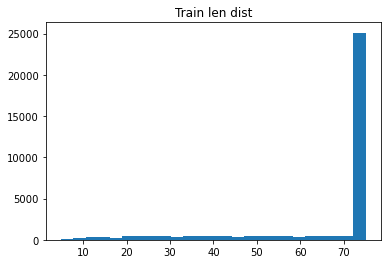

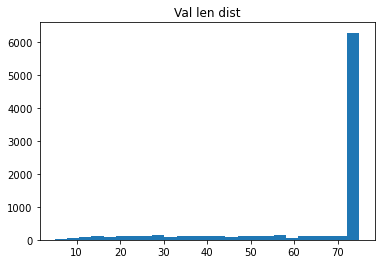

Train shapes: (torch.Size([35019, 75]), torch.Size([35019, 5]))
Test shapes: (torch.Size([8755, 75]), torch.Size([8755, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstms): LSTM(75, 128, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.67it/s, loss=6.765]
1/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  1.97it/s, loss=6.727]
[2020-11-16 11:17:06,211] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/999 * Epoch 1 (train): CMAP5=0.0164 | loss=7.3163
1/999 * Epoch 1 (valid): CMAP5=0.0267 | loss=6.7498
2/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.65it/s, loss=6.387]
2/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.02it/s, loss=6.402]
[2020-11-16 11:17:18,985] 
2/999 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/99

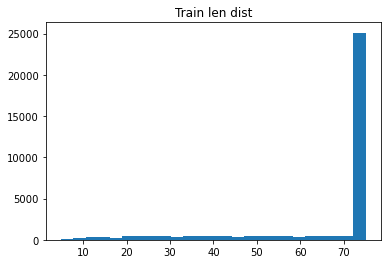

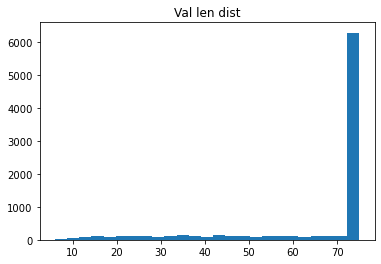

Train shapes: (torch.Size([35019, 75]), torch.Size([35019, 5]))
Test shapes: (torch.Size([8755, 75]), torch.Size([8755, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstms): LSTM(75, 128, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.65it/s, loss=6.786]
1/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.02it/s, loss=6.632]
[2020-11-16 11:23:19,547] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/999 * Epoch 1 (train): CMAP5=0.0186 | loss=7.2800
1/999 * Epoch 1 (valid): CMAP5=0.0275 | loss=6.7260
2/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.67it/s, loss=6.352]
2/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.05it/s, loss=6.288]
[2020-11-16 11:23:32,224] 
2/999 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/99

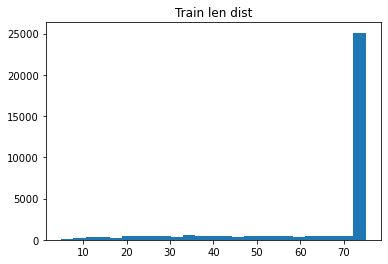

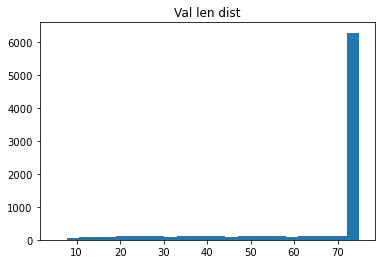

Train shapes: (torch.Size([35019, 75]), torch.Size([35019, 5]))
Test shapes: (torch.Size([8755, 75]), torch.Size([8755, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstms): LSTM(75, 128, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.64it/s, loss=6.723]
1/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.02it/s, loss=6.718]
[2020-11-16 11:29:17,372] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/999 * Epoch 1 (train): CMAP5=0.0173 | loss=7.2998
1/999 * Epoch 1 (valid): CMAP5=0.0264 | loss=6.6936
2/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.66it/s, loss=6.383]
2/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  1.94it/s, loss=6.413]
[2020-11-16 11:29:30,203] 
2/999 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/99

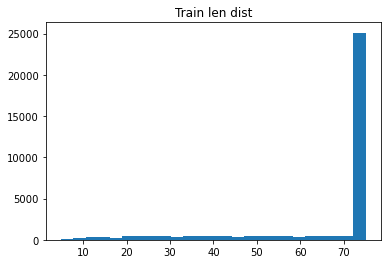

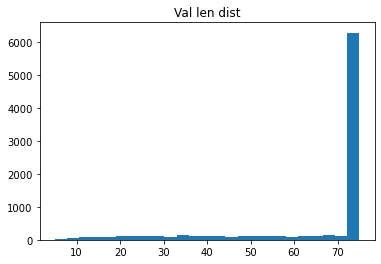

Train shapes: (torch.Size([35019, 75]), torch.Size([35019, 5]))
Test shapes: (torch.Size([8755, 75]), torch.Size([8755, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstms): LSTM(75, 128, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.67it/s, loss=6.790]
1/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.02it/s, loss=6.722]
[2020-11-16 11:35:30,286] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/999 * Epoch 1 (train): CMAP5=0.0178 | loss=7.2876
1/999 * Epoch 1 (valid): CMAP5=0.0271 | loss=6.7192
2/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.65it/s, loss=6.353]
2/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.02it/s, loss=6.430]
[2020-11-16 11:35:43,082] 
2/999 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/99

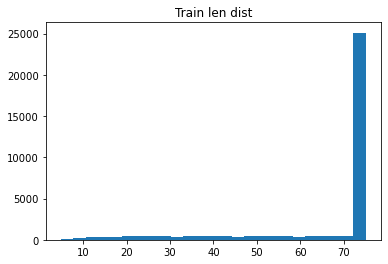

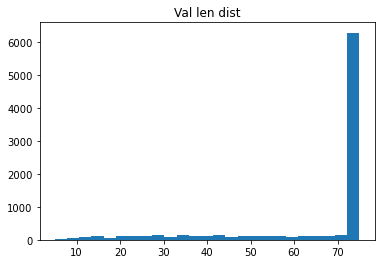

Train shapes: (torch.Size([35020, 75]), torch.Size([35020, 5]))
Test shapes: (torch.Size([8754, 75]), torch.Size([8754, 5]))
BaselineModel(
  (embeddding): Embedding(4844, 64, padding_idx=0)
  (rate_layer): Embedding(4844, 11)
  (emb_dropout): Dropout(p=0.01, inplace=False)
  (lstms): LSTM(75, 128, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=4843, bias=True)
  )
)
1/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.65it/s, loss=6.674]
1/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  2.00it/s, loss=6.555]
[2020-11-16 11:40:41,430] 
1/999 * Epoch 1 (_base): lr=0.0010 | momentum=0.000e+00
1/999 * Epoch 1 (train): CMAP5=0.0183 | loss=7.2802
1/999 * Epoch 1 (valid): CMAP5=0.0277 | loss=6.7110
2/999 * Epoch (train): 100% 17/17 [00:10<00:00,  1.66it/s, loss=6.292]
2/999 * Epoch (valid): 100% 5/5 [00:02<00:00,  1.97it/s, loss=6.227]
[2020-11-16 11:40:54,211] 
2/999 * Epoch 2 (_base): lr=0.0010 | momentum=0.000e+00
2/99

In [ ]:
all_val_targets = []
all_val_preds = []
all_test_preds = []

#for semechko in [1234,1,2,3,4,5,6,7,8,9]:
skf = StratifiedKFold(shuffle=True, random_state=1234, n_splits=5)

for f_id, (train_index, test_index) in enumerate(skf.split(X, lens_discrit)):
    print(f"Fold {f_id} started")

    train_X, train_y = X[train_index,:], y[train_index]
    val_X, val_y = X[test_index,:], y[test_index]

    train_x_lens = [(el != 0).sum() for el in train_X]
    val_x_lens = [(el != 0).sum() for el in val_X]

    plt.title('Train len dist')
    plt.hist(train_x_lens, bins=25)
    plt.show()

    plt.title('Val len dist')
    plt.hist(val_x_lens, bins=25)
    plt.show()

    
    train_function(
        torch.LongTensor(train_X),
        torch.LongTensor(train_y),
        torch.LongTensor(val_X),
        torch.LongTensor(val_y),
        f'../logdirs/{EXP_NAME}/fold_{f_id}'
    )
    


    avarage_weights(
            path_to_chkps=glob(f'../logdirs/{EXP_NAME}/fold_{f_id}/checkpoints/train.*_full.pth'),
            save_path=f'../logdirs/{EXP_NAME}/fold_{f_id}/checkpoints/swa_best.pth'
        )

    val_pred = inference_function(
        torch.LongTensor(val_X),
        f'../logdirs/{EXP_NAME}/fold_{f_id}'
    )
    val_pred = list(val_pred)
    val_target = list(val_y)
    fold_score = mean_average_precision_at_k(val_target, val_pred)
    print(f"Best score: {fold_score}")
    all_val_preds.append(val_pred)
    all_val_targets.append(val_target)

    all_test_preds.append(inference_function(
        torch.LongTensor(X_test),
        f'../logdirs/{EXP_NAME}/fold_{f_id}',
        return_logits=True
    ))


## Compute score and create submit

In [ ]:
len(all_val_targets), len(all_val_preds), len(all_test_preds)

In [ ]:
from itertools import chain
from scipy.special import softmax

In [ ]:
scores = [mean_average_precision_at_k(t,p) for t,p in zip(all_val_targets, all_val_preds)]

In [ ]:
print(f" Mean score : {np.mean(scores)}")
print(f" STD score : {np.std(scores)}")

plt.title('Scores')
plt.plot(scores);

In [ ]:
val_score = mean_average_precision_at_k(
    list(chain(*all_val_targets)), 
    list(chain(*all_val_preds))
)
print(f"OOF val score: {val_score}")

In [ ]:
losses = [
    torch.load(f'../logdirs/{EXP_NAME}/fold_{idx}_seed_1234/checkpoints/best.pth', map_location='cpu')['valid_metrics']['loss']
    for idx in range(1)
]
val_loss = np.mean(losses)
print(f" Mean losses : {np.mean(losses)}")
print(f" STD losses : {np.std(losses)}")

plt.title('losses')
plt.plot(losses);

In [ ]:
processed_test_preds = np.stack(all_test_preds, axis=0).mean(0)
processed_test_preds = np.argsort(-processed_test_preds)[:,:5]

In [ ]:
np.save(f'../test_preds/{EXP_NAME}.npy', np.array([
    all_test_preds,test_users_in_sequences, le_film_id.classes_
]))

In [ ]:
final_processed_test_preds = [le_film_id.inverse_transform(row) for row in processed_test_preds]
final_processed_test_preds = [' '.join(map(lambda x: str(x), row)) for row in final_processed_test_preds]

In [ ]:
sample_submission.index = sample_submission.user_id
sample_submission.loc[test_users_in_sequences, 'movie_id'] = final_processed_test_preds

In [ ]:
sample_submission

In [ ]:
sample_submission.to_csv(f'../subs/{EXP_NAME}_onemodel.csv', index=False)

In [ ]:
results = pd.read_csv('../exp_results.csv')
results

In [ ]:
results = results.append({
    'name':EXP_NAME,
    'score':val_score,
    'loss': val_loss
}, ignore_index=True)

In [ ]:
results

In [ ]:
results.to_csv('../exp_results.csv', index=False)